<a href="https://colab.research.google.com/github/rhehgus02/ESAA_OB/blob/main/%EC%BA%90%EA%B8%80_%EC%8B%A4%EC%8A%B5_%ED%95%84%EC%82%AC(4)_%EB%B9%84%EC%A7%80%EB%8F%84_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customers clustering: K-Means, DBSCAN and AP**

링크: https://www.kaggle.com/code/datark1/customers-clustering-k-means-dbscan-and-ap/notebook

이 프로젝트는 머신 러닝 알고리즘을 사용하여 마트 고객 세분화를 수행하는 방법을 보여줍니다. 이것은 비지도 클러스터링 문제이며, KMeans, Affinity Propagation, DBSCAN의 세 가지 인기 있는 알고리즘이 제시되고 비교될 것입니다.

---

## **1. Introduction**

The main task of clustering is to discover „natural“ groups within an unlabelled dataset - this means that's an unsuprvised ML task. And it's an important one, as as it is used in many scientific, engineering and business domains. One of the most known application of clustering are:

* customers segmentation (for efficient marketing)

* image segmentation

* documents clusterisation.

There are many clustering algorithms which can be divided into two main types: hierarchical and partitional.

* Hierarchical algorithms recursively split a dataset into a smaller subset until a subset contains only one item. This can be represented with a dendrogram which looks like a tree. It can be constructed from leaves to the roo(agglomerative approach) or from the root down to the leaves (divisive approach). In hierarchical clustering, you don’t have to specify the number of clusters but you have to define a termination condition for splitting/merging process.

* Partitional algorithms divide a dataset into several subsets (clusters) based on a given criteria. For some algorithms number of clusters has to be defined a priori (e.g K-Means) and for some not (DBSCAN). Defining the number of clusters before running an algorithm often requires a specific domain knowledge which is often challenging (or even impossible) in many applications. This led to the development of many heuristics and simplified approaches helping analyst without domain knowledge to choose the appropriate number of clusters.

---

## **2. Reading data**


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 1.5.3
numpy version: 1.23.5
seaborn version: 0.12.2


In [4]:
mall_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/OB/data/Mall_Customers.csv')
print('There are {} rows and {} columns in our dataset.'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset.


In [5]:
mall_data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
88,89,Female,34,58,60
112,113,Female,38,64,42
37,38,Female,30,34,73
111,112,Female,19,63,54
74,75,Male,59,54,47
44,45,Female,49,39,28
166,167,Male,42,86,20
109,110,Male,66,63,48
193,194,Female,38,113,91
68,69,Male,19,48,59


In [6]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


There are 5 columns:

* Customer ID - numerical - unique customer number - integer

* Gender - categorical - binary (Male/Female)

* Age - numerical - integer

* Annual Income (k$) - numerical - integer

* Spending Score (1-100) - numerical - integer

There is one binary, categorical
column: gender. You may be tempted to one-hot encode it for the clustering.

In [7]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [8]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


누락된 데이터가 없습니다. 이렇게 하면 분석이 간단해지지만 분석가들이 핵심 분석을 수행하기 전에 데이터를 정리하는 데 상당한 시간을 소비하는 현실에서는 매우 불가능한 시나리오입니다.

---

## **3. Exploratory Data Analysis**


이 섹션은 주어진 데이터베이스에 대한 기본적인 통계적 조사를 포함합니다. 이 섹션은 기본 데이터를 더 잘 이해할 수 있도록 하기 때문에 모든 분석에서 매우 중요한 부분입니다. 이 부분에는 분포와 상관 관계라는 두 가지 주요 섹션이 있습니다.

---

### **3-1. Distributions**


이 장에서는 수치 변수의 분포를 자세히 조사할 것입니다. 데이터는 유일한 범주형 변수인 성별에 따라 계층화됩니다.


<ipython-input-9-90e711b08c1a>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
<ipython-input-9-90e711b08c1a>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_age, bins=age_bins, kd

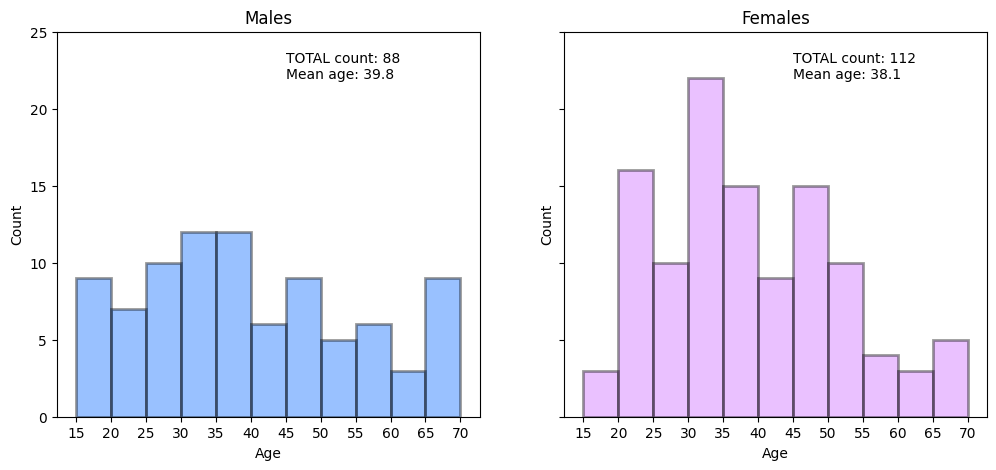

In [9]:
males_age = mall_data[mall_data['Gender']=='Male']['Age'] # subset with males age
females_age = mall_data[mall_data['Gender']=='Female']['Age'] # subset with females age

age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

In [10]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


>> 남성 고객의 평균 연령은 여성(39.8세 대 38.1세)보다 약간 높습니다. 남성 연령의 분포는 여성보다 균일한데, 여기서 우리는 가장 큰 연령대가 30-35세임을 관찰할 수 있습니다. Kolgomorov-Smirnov 검정 결과 두 그룹 간의 차이가 통계적으로 유의하지 않습니다.

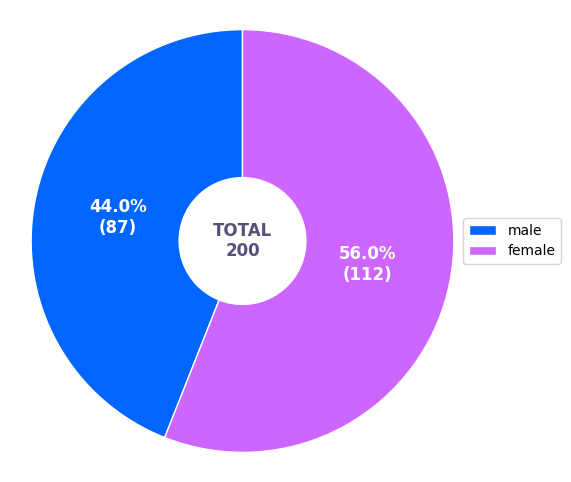

In [11]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

>> 여성 고객이 남성 고객보다 약간 더 많습니다(112명 대 87명). 전체 고객의 56%가 여성입니다.

<ipython-input-12-0d86fc4a2b23>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
<ipython-input-12-0d86fc4a2b23>:19: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_income, bins=my_bi

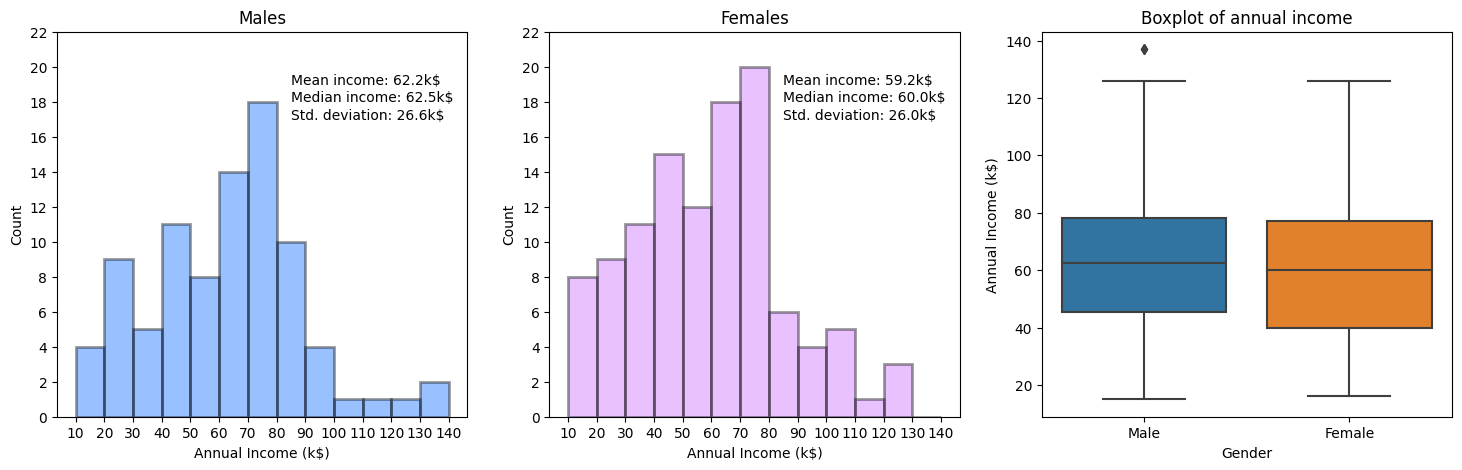

In [12]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

In [13]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

Kolgomorov-Smirnov test p-value: 0.78


>> 남성의 평균 소득은 여성보다 높습니다(62.2k 대 59.2k). 또한 남성 고객의 중위 소득(62.5k)이 여성(60k)보다 높습니다. 표준 편차는 두 그룹 모두에서 비슷합니다. 연간 소득이 약 140k인 남성 그룹에는 한 가지 이상치가 있습니다. K-S 검정은 이 두 그룹이 통계적으로 다르지 않음을 보여줍니다.

<ipython-input-14-95f80557e0ae>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
<ipython-input-14-95f80557e0ae>:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(females_spending, 

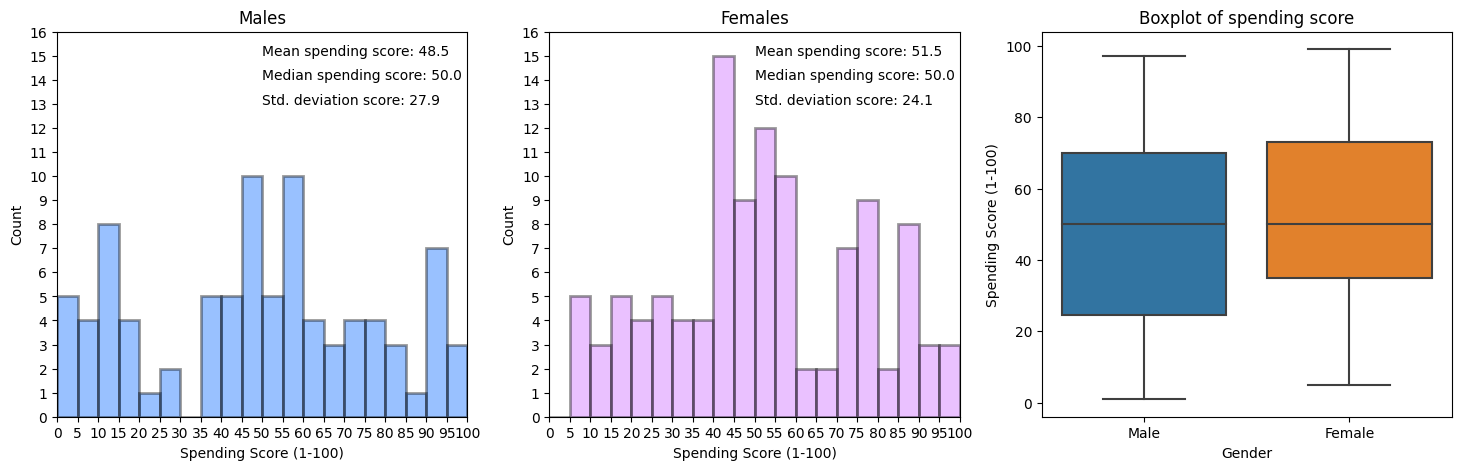

In [14]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

In [15]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))

Kolgomorov-Smirnov test p-value: 0.29


>> 평균 지출 점수는 여성(51.5)이 남성(48.5)보다 높습니다. K-S 검정 p-값은 귀무 가설을 기각할 증거가 없다는 것을 나타내지만, 증거는 이전의 비교와 같이 강력하지 않습니다. 다음은 모든 연령대의 중위 소득을 계산하겠습니다.

In [16]:
medians_by_age_group = mall_data.groupby(["Gender",pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)

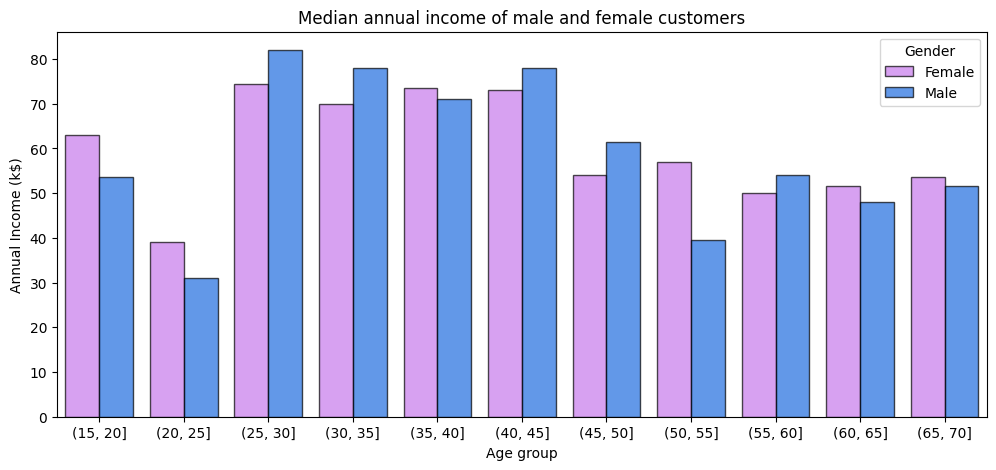

In [17]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

>> 위의 막대 차트는 가장 부유한 고객이 25-45세라는 것을 보여줍니다. 여성과 남성의 가장 큰 차이는 25-30세(남성 부자)와 50-55세(여성 부자 부자) 그룹에서 볼 수 있습니다.

---

### **3-2. Correlations**

This chapter investigates correlations between numerical variables.

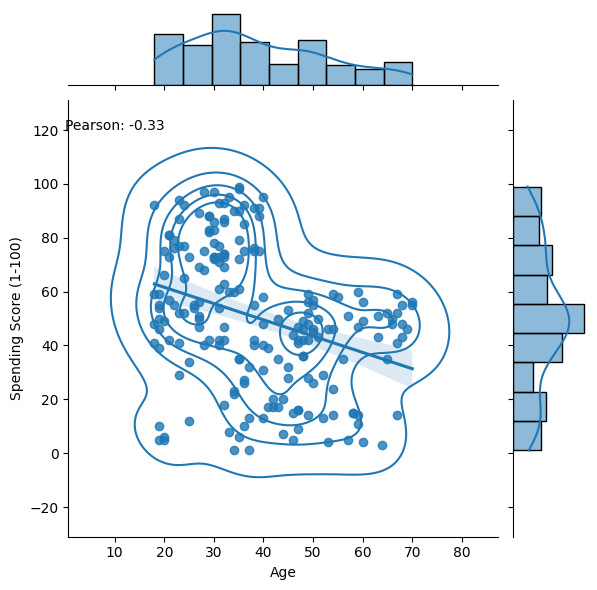

In [19]:
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])

jp = (sns.jointplot(x='Age', y='Spending Score (1-100)', data=mall_data,
                    kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(0,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

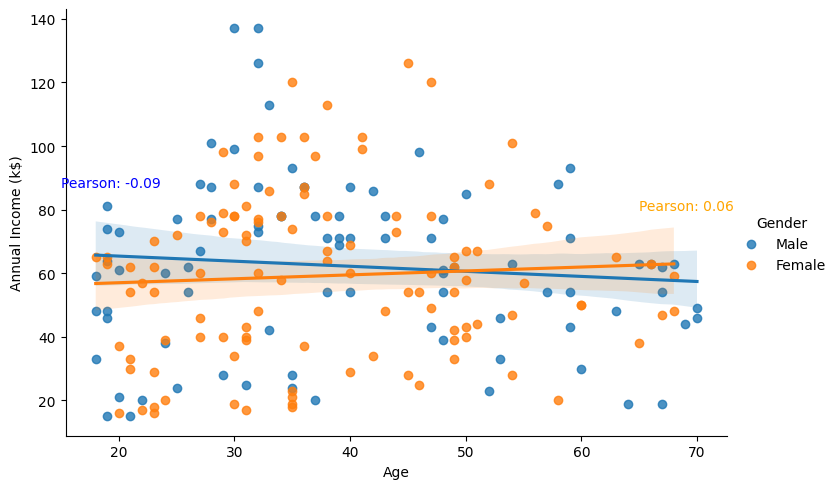

In [22]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot(x='Age', y='Annual Income (k$)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(15,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

>> 두 성별 집단 모두 고객의 연령과 연소득 사이에는 무시할만한 상관관계가 있습니다.

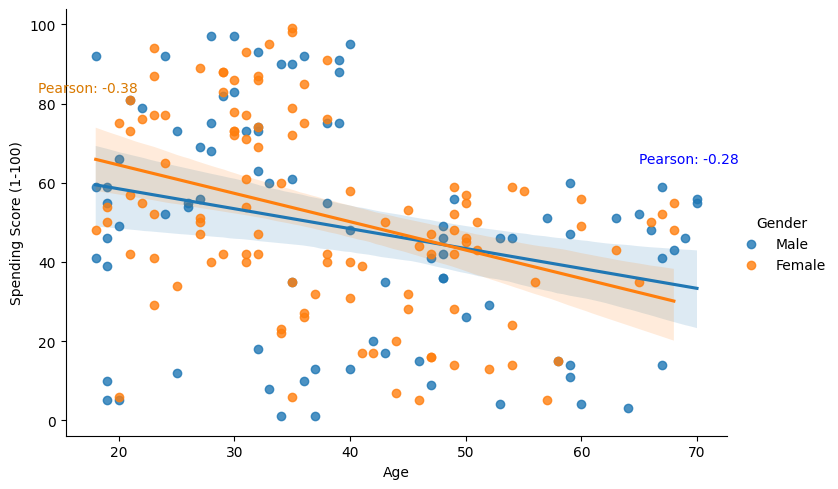

In [23]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot(x='Age', y='Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(65,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

>> 두 성별 집단의 연령과 지출 점수 사이에는 약한 음의 상관관계(<0.5)가 있습니다.

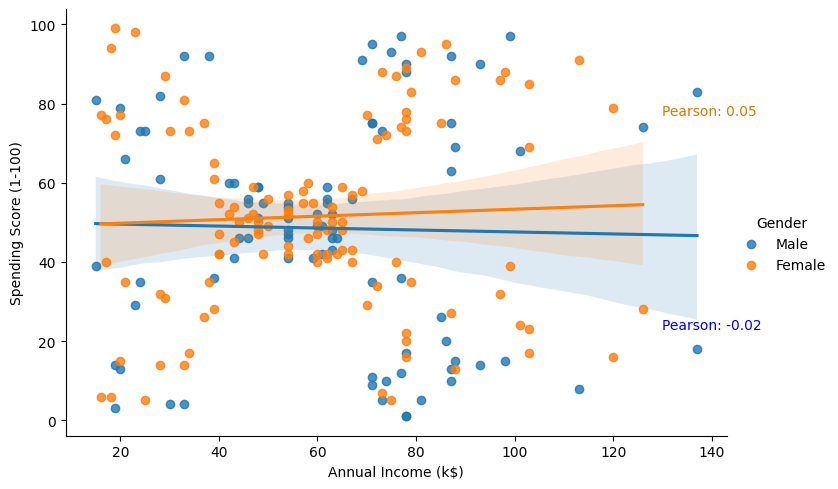

In [24]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

>> 두 성별 집단 모두 연간 수입과 소비자의 지출 점수 사이에는 무시할만한 상관관계가 있습니다.

---

## **4. Clustering**

이 노트의 이 섹션에서는 세 가지 클러스터링 알고리즘을 사용하는 방법을 설명하고 설명합니다:

* K-Means

* Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

* Affinity Propagation.



---

### **4-1. K-Means**

이 장에서는 대부분의 머신러닝 과정에서 매우 인기 있는 K-Means 알고리즘을 중심으로 설명합니다. 알고리즘에 대한 설명과 활용 사례(mall customers segmentation)의 두 가지 하위 장으로 구성되어 있습니다.

---

### **4-1-1. Description**

* K-Means 알고리즘(Lloyd's algorithm)의 세 단계

1. 시드 포인트를 사용하여 샘플을 초기 그룹으로 나눕니다. 이 시드 포인트에서 가장 가까운 샘플이 초기 클러스터를 생성합니다.

2. 그룹의 중심점(중심점)까지의 표본 거리를 계산하고 가장 가까운 표본을 해당 군집에 할당합니다.

3. 세 번째 단계는 새로 생성된(업데이트된) 클러스터 중심체를 계산하는 것입니다.

    -> 알고리즘이 수렴할 때까지 2단계와 3단계를 반복합니다

* K-Means의 목표는 모든 군집에 걸쳐 목적함수(inertia)를 최소화하는 것

* K-Means의 세 가지 주요 파라미터

    * 초기화 기준

    * 클러스터 수

    * 거리 metric (sickit learn 구현에 필요하지 않음)

---

### **4.1.2 Use case - customers segmentation**

클러스터링 분석의 첫 번째 단계는 sklearn 라이브러리에서 K-Means를 가져오는 것입니다.

In [25]:
from sklearn.cluster import KMeans

군집화의 경우 숫자 열만 사용됩니다. 처음에 언급된 것처럼 이진 변수 성별은 여기서 사용되지 않습니다.

In [26]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only

적절한 군집의 수를 찾기 위해 팔꿈치 방법이 사용될 것입니다. 이 경우 이 방법에서는 2에서 10 사이의 군집의 수에 대한 관성이 계산됩니다. 규칙은 그래프에서 꺾임 또는 "팔꿈치"가 나타나는 군집의 수를 선택하는 것입니다.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

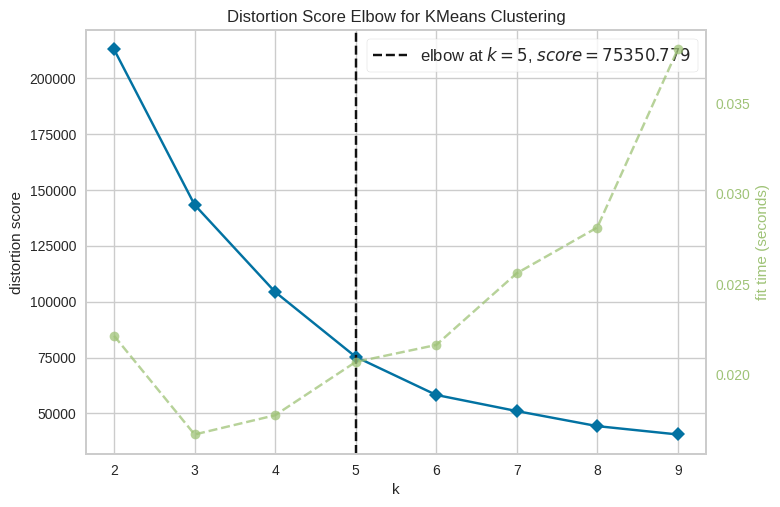

In [28]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

>> 위의 그래프는 군집의 수가 증가함에 따라 왜곡 점수가 감소하는 것을 보여줍니다. 그러나 명확한 "팔꿈치"가 보이지 않습니다. 기본 알고리즘은 5개의 군집을 제안합니다. 5개 또는 6개의 군집 선택이 공정한 것으로 보입니다.

가장 좋은 군집의 수를 선택하는 또 다른 방법은 군집의 수에 대한 함수에 실루엣 점수를 표시하는 것입니다. 결과를 보겠습니다.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

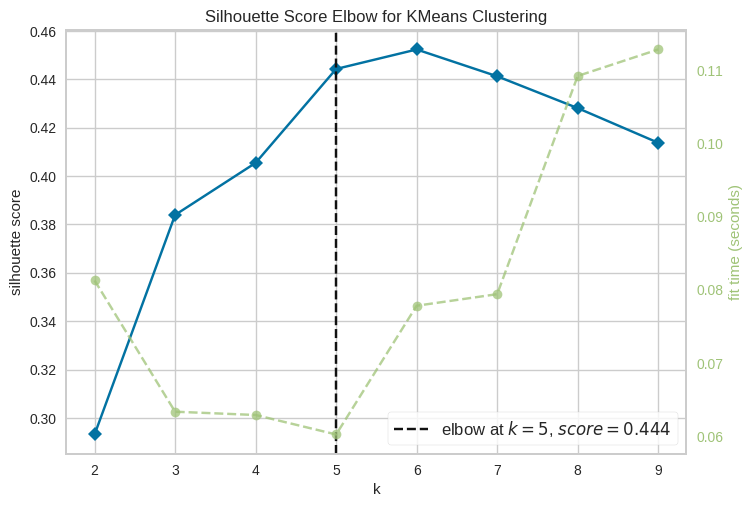

In [29]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

>> 실루엣 점수법에 따르면 5개 또는 6개의 클러스터가 가장 좋을 것으로 예상됩니다. 두 가지를 비교해 보겠습니다.

#### **5 CLUSTERS**

In [30]:
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


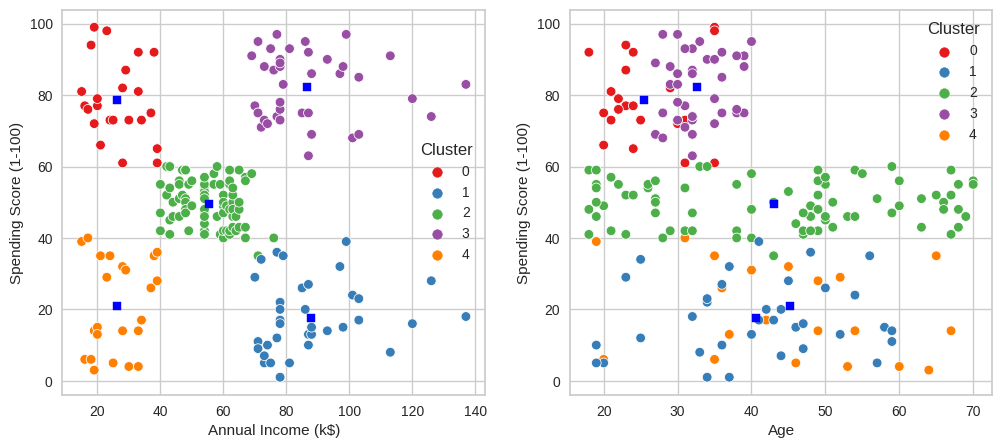

In [32]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot(data=KM5_clustered, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(data=KM5_clustered, x='Age', y='Spending Score (1-100)',
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

K-Means 알고리즘은 다음과 같은 5개의 클러스터를 생성했습니다:

* 연간 수입이 낮고 지출 점수가 높은 고객들

* 연간 수입이 중간이고 지출이 중간인 고객

* 연간 수입이 높고 지출 점수가 낮은 고객들

* 연간 수입이 높고 지출 점수가 높은 고객

* 연간 수입이 낮고 지출 점수가 낮은 고객들

고객 연령에 따라 다른 그룹이 없습니다.

#### **Sizes of the clusters:**

In [33]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,23
1,36
2,79
3,39
4,23


>> 가장 큰 클러스터는 79개의 관측치("중간" 클라이언트)를 가진 1번 클러스터입니다. 각각 23개의 관측치를 포함하는 2개의 가장 작은 클러스터가 있습니다(3번 "높음" 클라이언트와 0번 "낮음" 클라이언트). 아래에는 5개의 생성된 클러스터의 3D 투영이 있습니다.

In [37]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM5_clustered['Age'],
           KM5_clustered['Annual Income (k$)'],
           KM5_clustered['Spending Score (1-100)'],
           c=KM5_clustered['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

<ipython-input-37-2aceea3e6f93>:11: MatplotlibDeprecationWarning:

The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.

<ipython-input-37-2aceea3e6f93>:12: MatplotlibDeprecationWarning:

The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.

<ipython-input-37-2aceea3e6f93>:13: MatplotlibDeprecationWarning:

The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.

<ipython-input-37-2aceea3e6f93>:18: MatplotlibDeprecationWarning:

The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.



<Figure size 700x700 with 0 Axes>

In [36]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

각 군집의 품질을 확인하기 위해 실루엣 그림을 조사할 수 있습니다.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



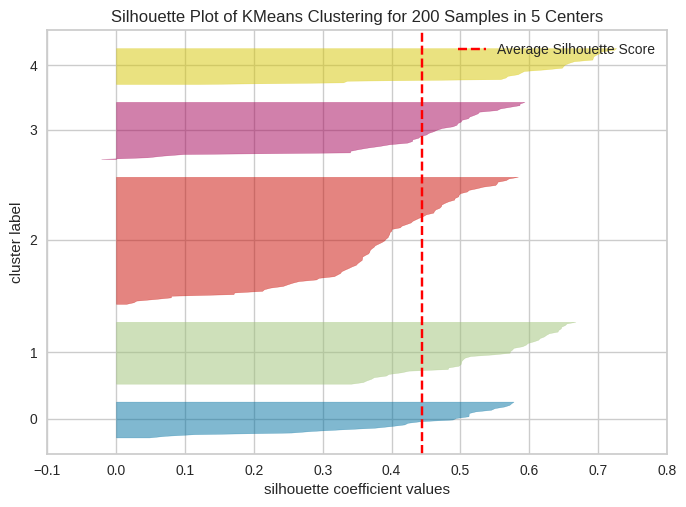

In [38]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

#### **6 CLUSTERS**

In [39]:
KM_6_clusters = KMeans(n_clusters=6, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_ # append labels to points

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



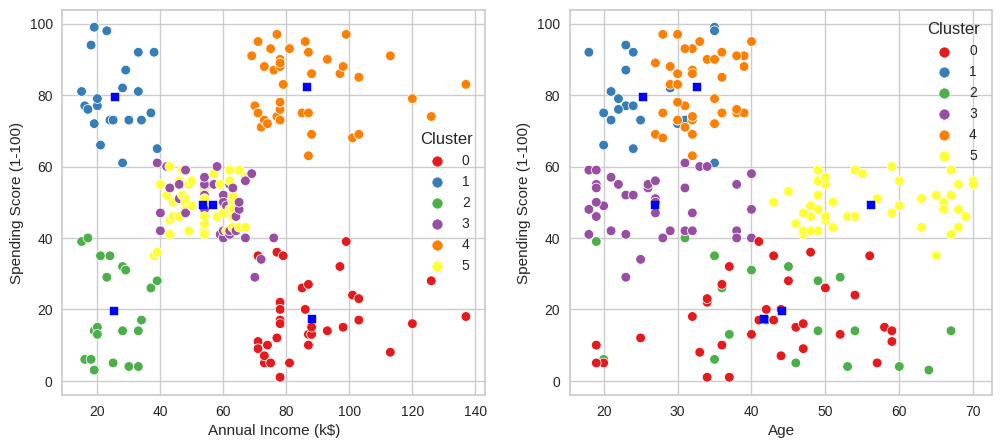

In [40]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

K-Means 알고리즘은 다음과 같은 6개의 클러스터를 생성했습니다:

* **medium** 연간 및 **medium** 지출 점수가 있는 젊은 고객

* **높은** 년 수입과 **낮은** 지출 점수를 가진 고객

* **medium** 연간 및 **medium** 지출 점수가 있는 젊은 고객

* **high** 연간 수입과 **high** 지출 점수를 가진 고객

* **낮은** 연 수입과 **낮은** 지출 점수를 가진 고객

* **낮은** 연 수입과 **높은** 지출 점수를 가진 고객

고객 연령에 따라 다른 그룹이 없습니다.

In [41]:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ["KM_size"]
KM6_clust_sizes

,KM_size
Cluster,
0,35
1,22
2,21
3,38
4,39
5,45


In [42]:
# Plotly interactive 3D plot

trace0 = tracer(KM6_clustered, 0, 'Cluster 0')
trace1 = tracer(KM6_clustered, 1, 'Cluster 1')
trace2 = tracer(KM6_clustered, 2, 'Cluster 2')
trace3 = tracer(KM6_clustered, 3, 'Cluster 3')
trace4 = tracer(KM6_clustered, 4, 'Cluster 4')
trace5 = tracer(KM6_clustered, 5, 'Cluster 5')

data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



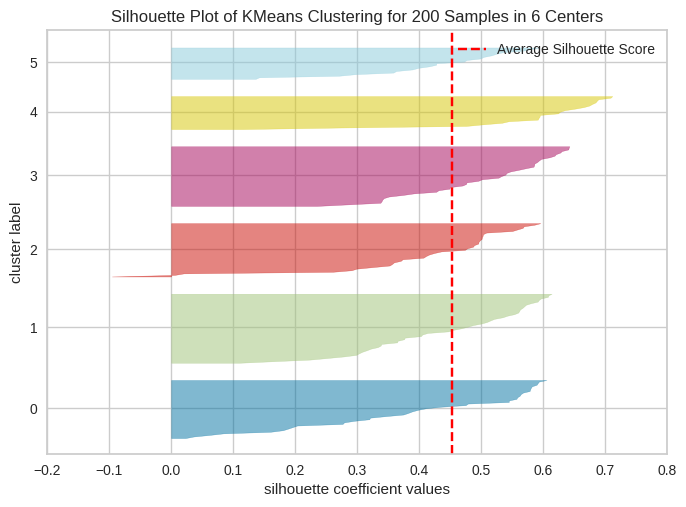

In [43]:
model = KMeans(n_clusters=6, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

---

### **4-2. DBSCAN**

이 장에서는 DBSCAN의 작동 방식을 설명하고 mall 고객 세분화에 구현 방법을 보여 줍니다.

---

### **4-2-1. Description**

논문의 이름에서 알 수 있듯이 DBSCAN의 핵심 아이디어는 밀집 지역 개념을 중심으로 합니다. 자연 클러스터는 밀집된 위치에 있는 점들로 구성되어 있다는 가정입니다. 이를 위해서는 "밀집 지역"의 정의가 필요합니다. 이를 위해서는 DBSCAN 알고리즘에 필요한 두 개의 파라미터가 필요합니다.

* Eps, ε - 거리

* MinPts – 거리 내 최소 점 수Eps

선택적으로 거리 메트릭은 사용자에 의해 지정될 수 있지만 일반적으로 유클리드 거리가 구현됩니다(사이킷런 학습에서와 같이).

---

### **4-2-2. Use case - customers segmentation**

In [44]:
from sklearn.cluster import DBSCAN

DBSCAN에는 두 가지 주요 하이퍼 파라미터가 있습니다:

* eps

* min_samples

어떤 값이 가장 효과적인지 자의적으로 말하기 어려우므로 먼저 조사된 조합의 행렬을 만들겠습니다.

In [45]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

DBSAN은 이 두 매개 변수를 기반으로 클러스터를 자체적으로 생성하므로 생성된 클러스터 수를 확인해 보겠습니다.

In [46]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

아래 열 그림은 각 모수 조합에 대해 DBSAN 알고리즘에 의해 생성된 군집의 수를 보여줍니다.

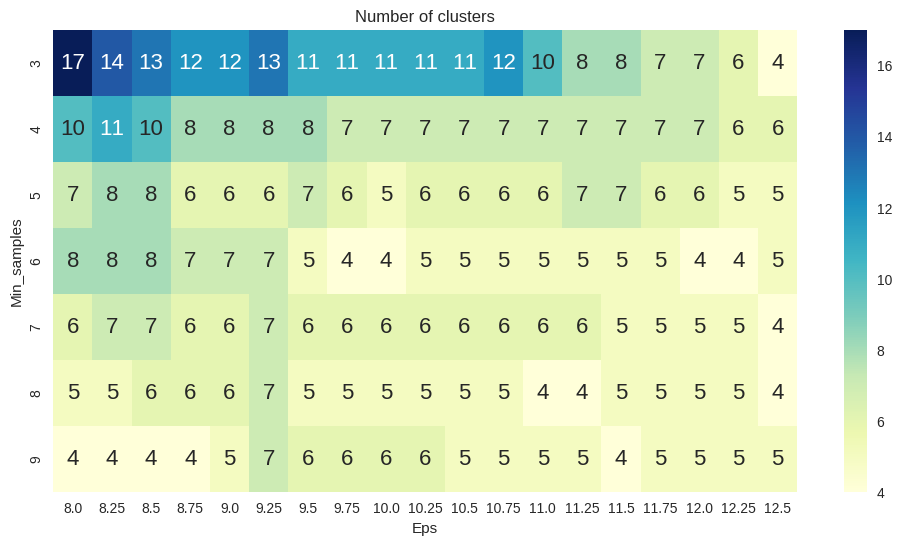

In [47]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

>> 위의 열 그림은 군집의 수가 17개에서 4개로 다양하다는 것을 보여줍니다. 그러나 대부분의 조합은 4-7개의 군집을 제공합니다. 어떤 조합을 선택할지 결정하기 위해 실루엣 점수인 메트릭을 사용하고 다시 열 지도로 표시합니다.

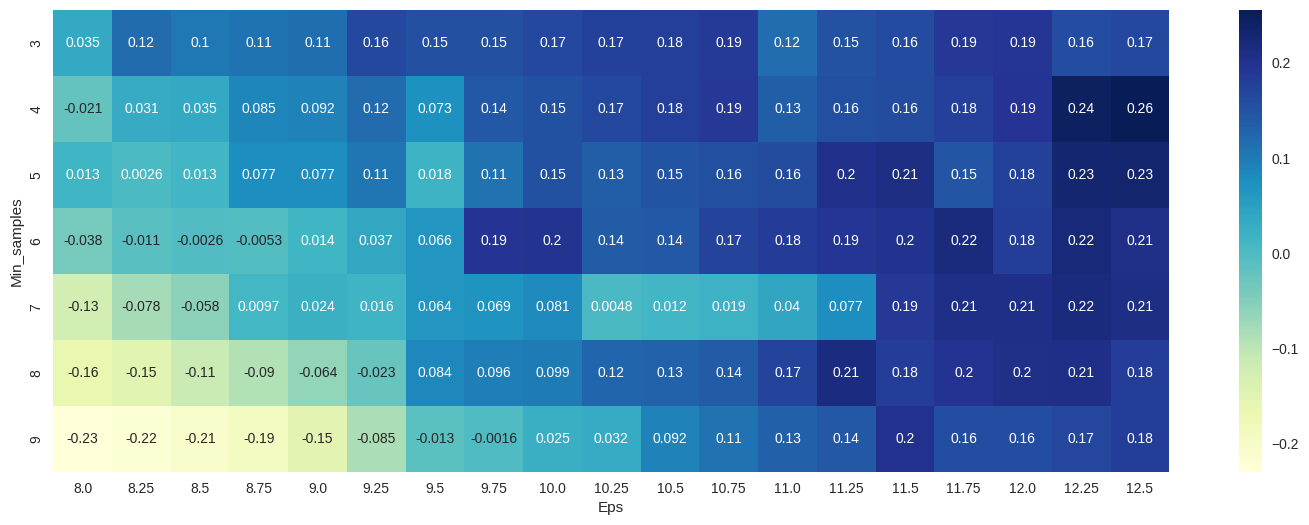

In [48]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

>> 글로벌 최대값은 eps=12.5 및 min_ samples=4의 경우 0.26입니다.

In [49]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

In [50]:
# Checking sizes of clusters.
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


>> DBSCAN은 5개의 군집과 특이치 군집(-1)을 생성했습니다. 군집 0-4의 크기는 매우 다양합니다. 일부는 관측치가 4개 또는 8개에 불과합니다. 이상치는 18개입니다.

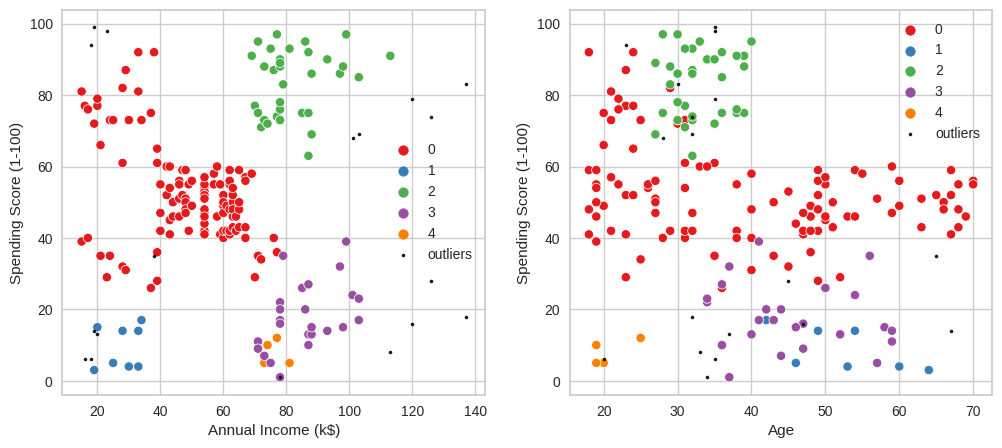

In [51]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot(x='Age', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

>> 위의 그래프는 일부 특이치가 있음을 보여 줍니다. 이 점들이 군집으로 인식되기 위한 거리 및 최소 표본 요구 조건을 충족하지 못합니다.

---

### **4.3 Affinity Propagation**

This chapter describes how Affinity Propagation works and shows its implementation to the mall customers segmentation.

---

### **4-3-1. Description**

Affinity Propagation은 수렴할 때까지 한 쌍의 포인트 사이에 메시지를 보내는 개념을 중심으로 구성됩니다. 이 메시지들은 이 두 포인트가 서로 얼마나 유사한지를 측정하는 방법이며 서로의 모범이 될 수 있습니다. 알고리즘은 최적의 클러스터 수 자체를 찾습니다. 이것은 또한 O(n²T) 차수의 시간 복잡도 비용이 매우 높다는 것을 의미하며, 여기서 n은 샘플 수, T는 수렴할 때까지의 반복 횟수입니다. 그러나 AP의 큰 장점은 초기화 기준에 대한 민감도가 없다는 것입니다.

* 두 개의 파라미터

    * Preference which is a negative number and controls how many exemplars are used

    * Damping factor which prevents numerical oscillations when updating messages

---

### **4-3-2 Use case - customers segmentation**


In [52]:
from sklearn.cluster import AffinityPropagation

In [53]:
no_of_clusters = []
preferences = range(-20000,-5000,100) # arbitraty chosen range
af_sil_score = [] # silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))

af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head() # display only 5 best scores

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



,preference,clusters,sil_score
82,-11800.0,6.0,0.451649
27,-17300.0,6.0,0.451491
51,-14900.0,6.0,0.451491
52,-14800.0,6.0,0.451440
28,-17200.0,6.0,0.451440


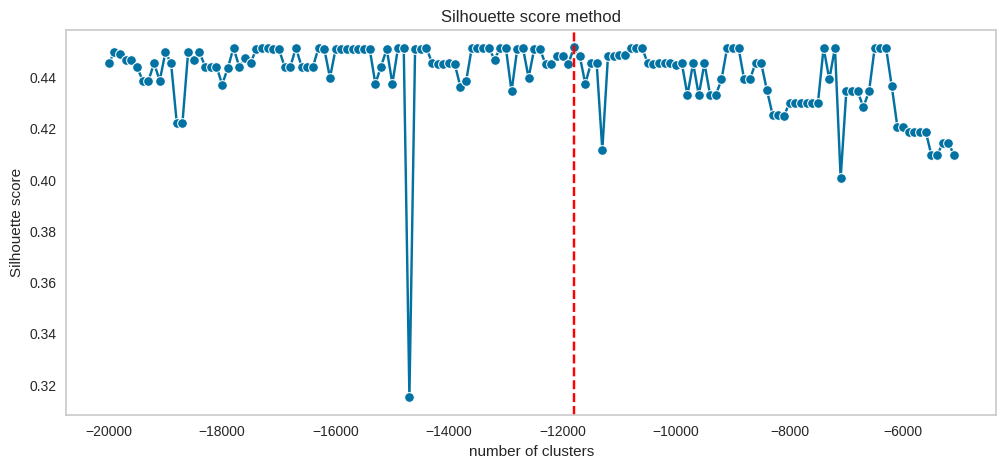

In [54]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x=preferences, y=af_sil_score, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [55]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [56]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [57]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


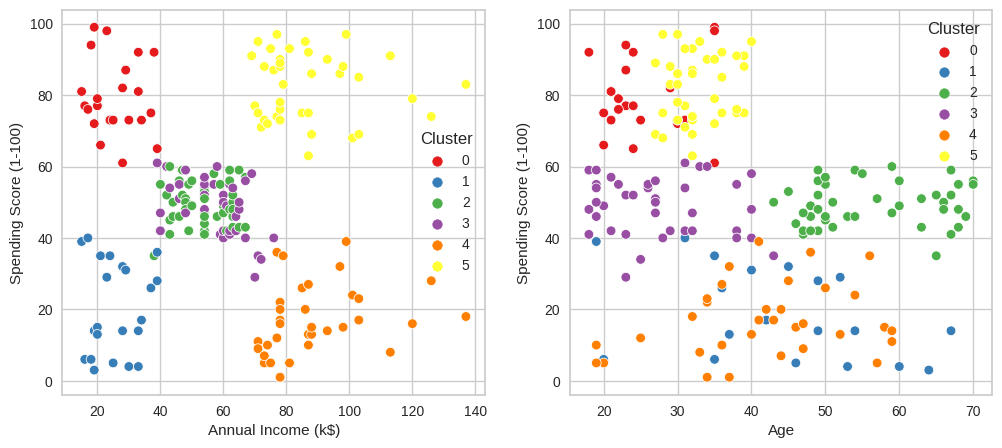

In [58]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

>> 생성된 클러스터는 K-Means에 의해 생성된 것과 유사한 비교적 고른 크기의 클러스터를 생성했습니다.

---

## **5. Comparison and discussion**

이 장에서는 3개의 조사된 알고리즘에 의해 생성된 클러스터를 비교하고 논의할 것입니다.


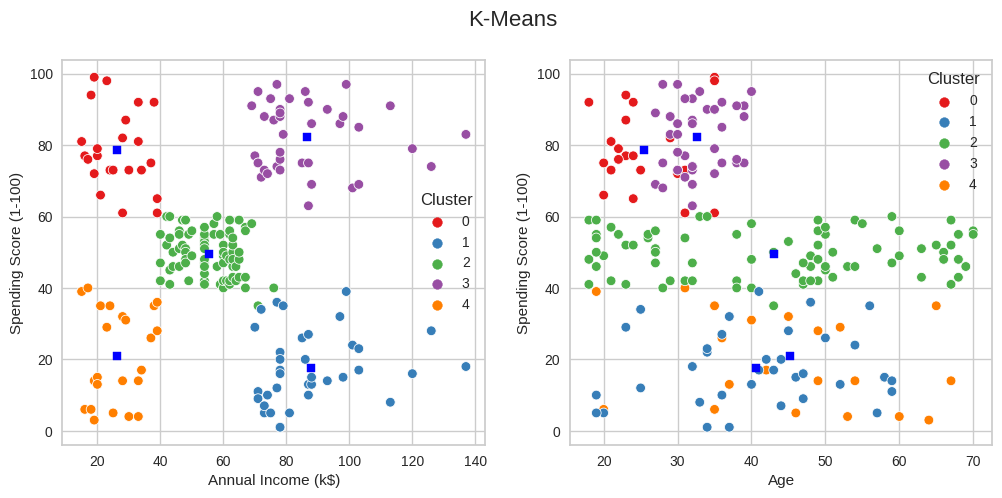

In [59]:
fig1.suptitle('K-Means', fontsize=16)
fig1

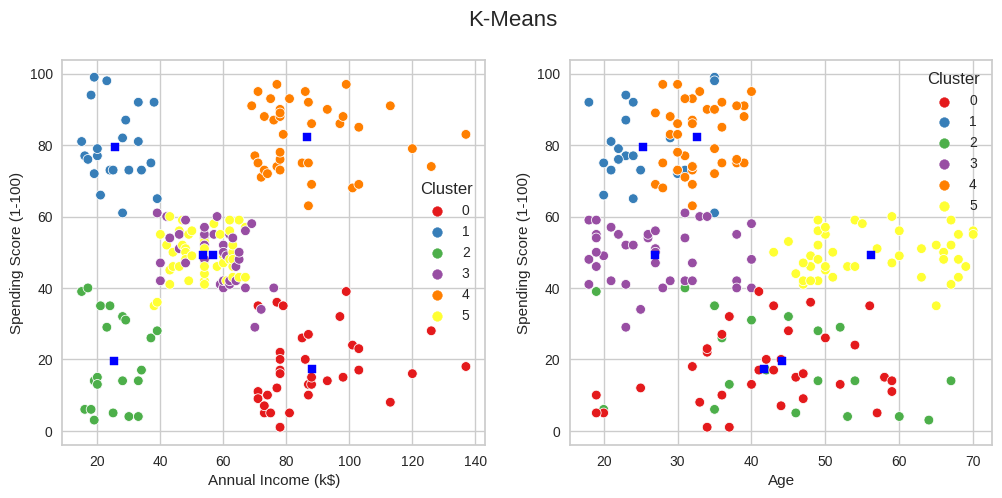

In [60]:
fig11.suptitle('K-Means', fontsize=16)
fig11

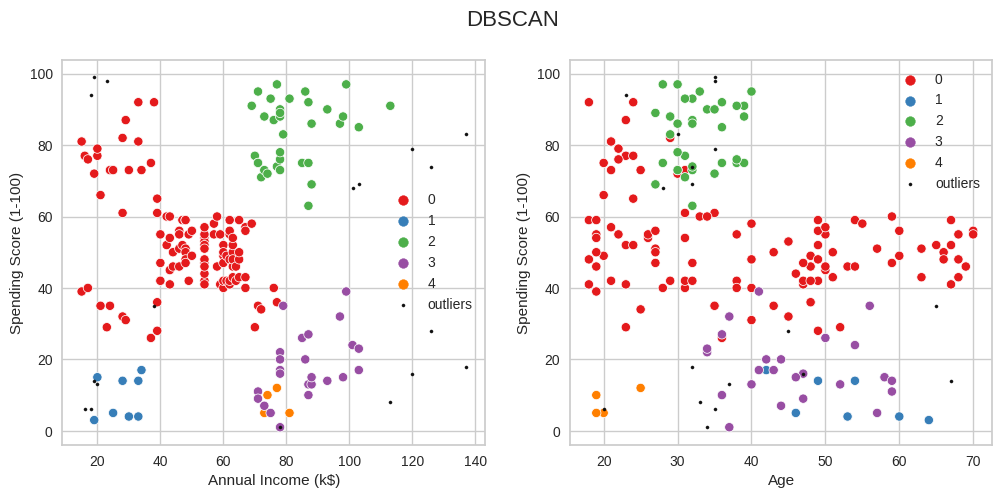

In [61]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

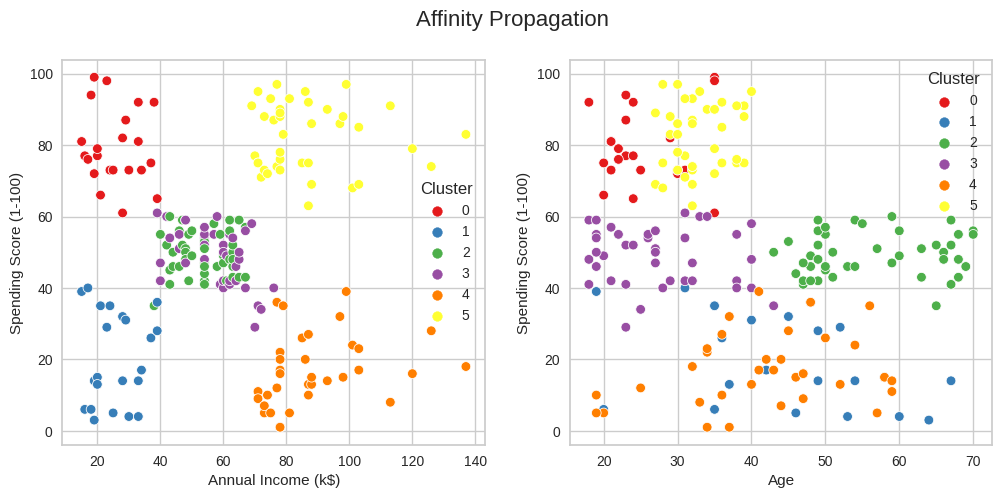

In [62]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

아래 표는 생성된 클러스터의 크기를 보여줍니다. 클러스터 번호는 각 방법마다 다릅니다. 예를 들어 K-평균의 클러스터 번호 0은 DBSAN의 클러스터 번호 2와 친화도 전파의 클러스터 번호 2와 같습니다.

In [63]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
0,35.0,112.0,22.0
1,22.0,8.0,22.0
2,21.0,34.0,44.0
3,38.0,24.0,39.0
4,39.0,4.0,34.0
5,45.0,NaN,39.0
-1,NaN,18.0,NaN


위의 비교를 통해 볼 때, DBSAN이 합리적인 클러스터를 생성하지 못했다는 것이 명백합니다. DBCSAN이 점의 밀도를 기반으로 클러스터를 찾으려고 시도하기 때문일 가능성이 높습니다. 우리의 클러스터 중 하나가 다른 클러스터보다 밀도가 낮으면 DBSAN은 최소 밀도의 그룹을 클러스터로 인식하지 않음으로써 차선의 결과를 생성할 것입니다.

결과적으로 K-평균 및 친화도 전파 알고리즘은 합리적인 6개의 클러스터를 만들었습니다.